# Getting started with timeseries

<p> This notebook walks you through some of the basic methods in PTSA's timeseries class. We'll see how to construct an instance of timeseries, how to save and load data, as well as resampling and filtering the timeseries. </p>  

In [1]:
# relevant imports
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook
from ptsa.data.TimeSeriesX import TimeSeriesX as timeseries

/home1/liyuxuan/anaconda3/envs/PTSA/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Let's start with creating some data

<p>In real applications, you will most likely have your own timeseries data for analysis.  
For the purpose of illustrating the functionalities of the timeseries class, we will construct sinusoids as our timeseries data.  
Let's create an array of 5000 data points, or samples. Suppose the sampling rate is 10Hz, this means that our timeseires is 5000/10=500 seconds long.
</p>

In [2]:
num_points = 5000
sample_rate = 10.

# We can specify the timestamps for each data point, from 0s to 500s.
t = np.linspace(1, num_points, num_points) / sample_rate

# Let's create two noisy sinusoids with different frequencies.
frequency1 = .5 # 1 cycle every 2 seconds
frequency2 = .1 # 1 cycle every 10 seconds
data1 = np.sin(2*np.pi*frequency1*t) + np.random.uniform(-0.5, 0.5, num_points)
data2 = np.sin(2*np.pi*frequency2*t) + np.random.uniform(-0.5, 0.5, num_points)

<p>Let's check our timepoints.</p>

In [3]:
print 'First 5 timestamps: ', t[:5]
print 'Last 5 timestamps: ', t[-5:]

First 5 timestamps:  [0.1 0.2 0.3 0.4 0.5]
Last 5 timestamps:  [499.6 499.7 499.8 499.9 500. ]


<p>We can also visualize the timeseries using matplotlib.</p>

<IPython.core.display.Javascript object>


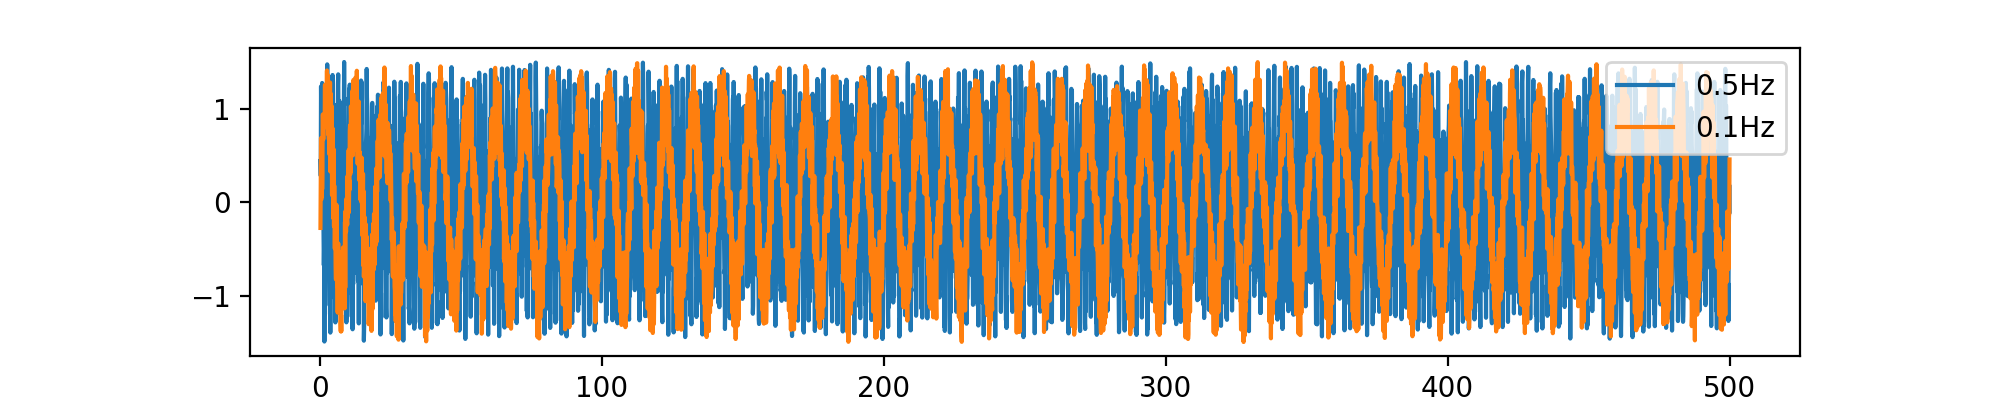

In [4]:
plt.figure(figsize=[10,2])
plt.plot(t, data1, label='%sHz'%str(frequency1))
plt.plot(t, data2, label='%sHz'%str(frequency2))

plt.legend()

<p>As we zoom in to the data array, the random noise we added to the sinusoids becomes clear.</p>

<IPython.core.display.Javascript object>


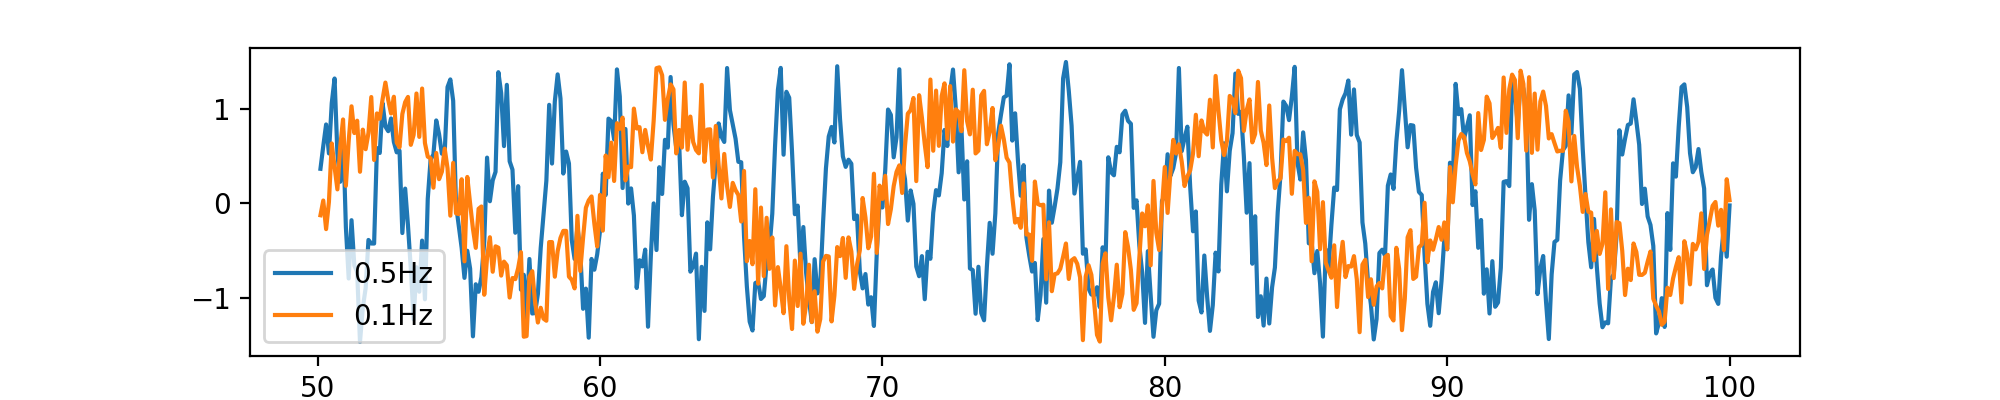

In [5]:
plt.figure(figsize=[10, 2])
plt.plot(t[500:1000], data1[500:1000], label='%sHz'%str(frequency1))
plt.plot(t[500:1000], data2[500:1000], label='%sHz'%str(frequency2))
plt.legend()

## 2. Create a timeseries object

<p>The timeseries class is a convenient wrapper of xarray that offers basic functionalities for timeseries analysis. Although we focus our analysis here in the context of timeseries data, many of the following examples can be easily extended to non-timeseries, multidimensional data.  
To create a timeseries object, we simply need to construct dimensions and the corresponding coordinates in each dimension.</p>

In [6]:
# Let's stack the two time-series data arrays.
data = np.vstack((data1, data2))

# and construct the timeseries object
ts = timeseries(data,
                dims=('frequency', 'time'),
                coords={'frequency':[frequency1, frequency2],
                        'time':t,
                        'samplerate':sample_rate})
print ts

<xarray.TimeSeriesX (frequency: 2, time: 5000)>
array([[ 0.438787,  0.281   ,  1.237331, ..., -0.142561,  0.181851, -0.102877],
       [-0.277042,  0.243351,  0.684427, ..., -0.144233, -0.12601 ,  0.45529 ]])
Coordinates:
    samplerate  float64 10.0
  * frequency   (frequency) float64 0.5 0.1
  * time        (time) float64 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 ...


<p>timeseries also has a convenient plotting method, inherited from xarray.</p>
<p> Note: since the frequency dimension has float coordinates, we want to be careful for exact float comparisons. Thus, instead of using *ts.sel(frequency=frequency1)*, we use *ts.sel(frequency=ts.frequency[0])*.</p>

<IPython.core.display.Javascript object>


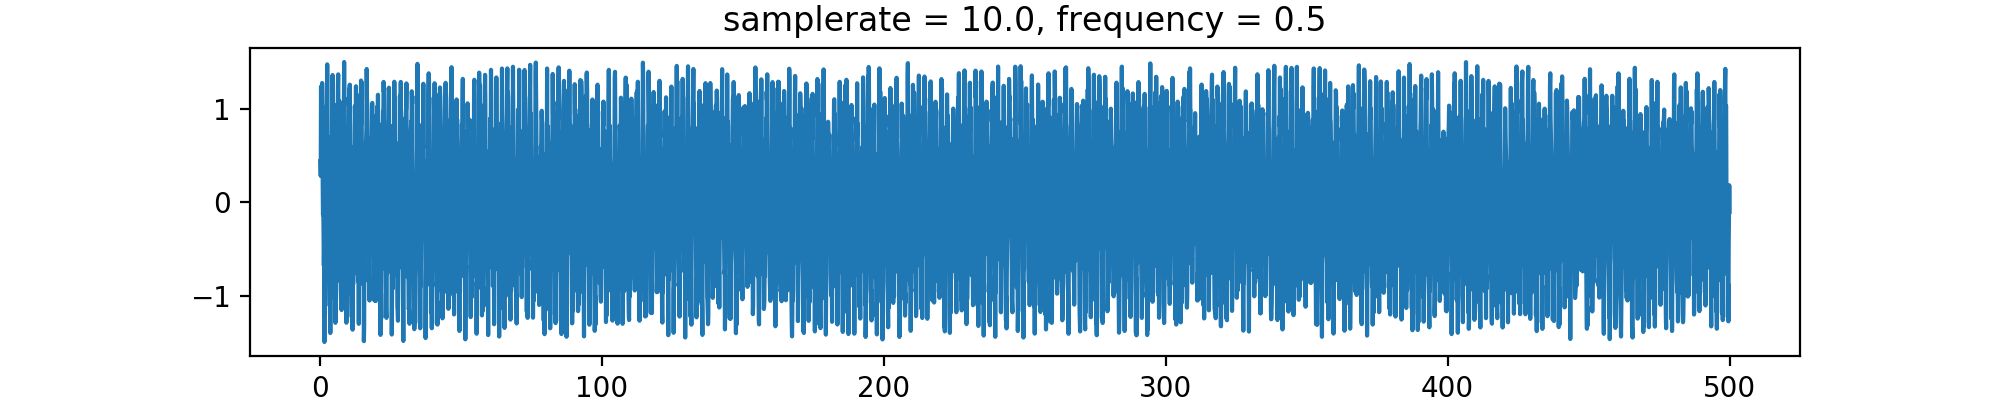

In [7]:
plt.figure(figsize=[10,2])
ts.sel(frequency=ts.frequency[0]).plot()

## 3. Saving and loading your data
<p>timeseries objects can be easily saved and loaded in HDF5 format. </p>
<p>Note: You will need to install h5py to use these methods.</p>

In [8]:
# use to_hdf to save data
fname = 'my_ts_data.h5'
ts.to_hdf(fname)

In [9]:
# use from_hdf to load data
ts = timeseries.from_hdf(fname)
print ts

<xarray.TimeSeriesX (frequency: 2, time: 5000)>
array([[ 0.438787,  0.281   ,  1.237331, ..., -0.142561,  0.181851, -0.102877],
       [-0.277042,  0.243351,  0.684427, ..., -0.144233, -0.12601 ,  0.45529 ]])
Coordinates:
    samplerate  float64 10.0
  * frequency   (frequency) float64 0.5 0.1
  * time        (time) float64 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 ...


## 4. Indexing your data

<p>We can used xarray's .sel() method to index our data, or give the dimension name instead of the dimension index to other methods.</p>
<p> Click [here](http://xarray.pydata.org/en/stable/index.html) to learn more about xarray methods. </p>

In [10]:
# Select the data from 100s to 200s
ts.sel(time=(ts.time>100)&(ts.time<200))

<xarray.TimeSeriesX (frequency: 2, time: 999)>
array([[ 0.330544,  0.341706,  0.971592, ..., -0.953735, -0.857463, -0.251036],
       [ 0.199096,  0.134058,  0.344616, ..., -0.294772, -0.246949,  0.316448]])
Coordinates:
    samplerate  float64 10.0
  * frequency   (frequency) float64 0.5 0.1
  * time        (time) float64 100.1 100.2 100.3 100.4 100.5 100.6 100.7 ...

In [11]:
# mean over the time dimension
ts.mean('time')

<xarray.TimeSeriesX (frequency: 2)>
array([-0.003606,  0.006691])
Coordinates:
    samplerate  float64 10.0
  * frequency   (frequency) float64 0.5 0.1

## 5. Matching coordinates

<p>We can also place the time dimension as the first dimension. The coordinates in xarray are very useful and are used to keep track of the dimensions of the data. Therefore, the exact shape of the data or the order of the dimensions can vary.</p>

In [12]:
ts_transpose = ts.T

print ts_transpose

<xarray.TimeSeriesX (time: 5000, frequency: 2)>
array([[ 0.438787, -0.277042],
       [ 0.281   ,  0.243351],
       [ 1.237331,  0.684427],
       ...,
       [-0.142561, -0.144233],
       [ 0.181851, -0.12601 ],
       [-0.102877,  0.45529 ]])
Coordinates:
    samplerate  float64 10.0
  * frequency   (frequency) float64 0.5 0.1
  * time        (time) float64 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 ...


<p>We can try adding the original timeseries and its "transposed" version together. Because their coordinates match, operations can be performed between them even though the data arrays are technically of different shapes.  
Note that because the transposed version of the data has the same value at every coordinate, by adding them together we're effectively doubling the values.</p>

<IPython.core.display.Javascript object>


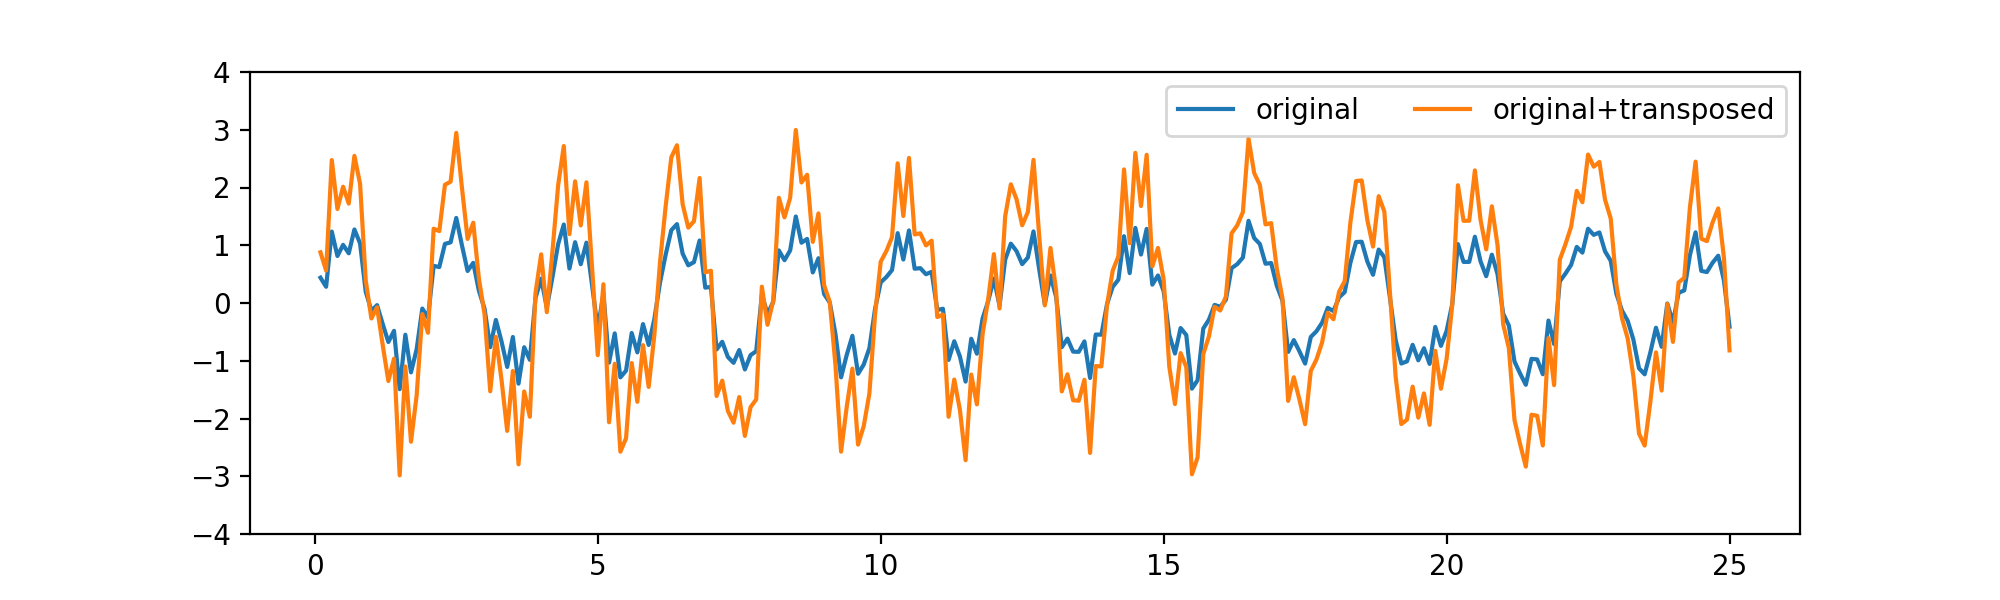

In [13]:
results = ts + ts_transpose

plt.figure(figsize=[10, 3])

# we'll only plot the first 250 samples to see things clearly
plt.plot(ts.time[:250], ts.sel(frequency=ts.frequency[0])[:250], label='original')
plt.plot(results.time[:250], results.sel(frequency=ts.frequency[0])[:250], label='original+transposed')
plt.ylim([-4,4])
plt.legend(ncol=2)

<p>Without the coordinates, the data cannot be added because their shapes wouldn't match.</p>

In [14]:
try:
    print (data+data.T)
except Exception as e:
    print 'Error: ' + str(e)

Error: operands could not be broadcast together with shapes (2,5000) (5000,2) 


<p>Note that sometimes, this feature can produce undesired results. Suppose that we want to subtract a subset of our data from another subset of our data, because xarray matches coordinates, it will drop all unmatched coordinates and return 0 at each matched coordinate.</p>

In [15]:
# Recall that our data contains 5000 points. 
# Let's select the first 3000 points and the last 3000 points and subtract one from the other.
# The result is all zeros because unmatched coordinates are dropped, 
# and the value at each of the 1000 overlapping coordinates is subtracted from itself.

early_ts = ts.sel(time=ts.time[:3000])
late_ts = ts.sel(time=ts.time[2000:])

late_ts - early_ts

<xarray.TimeSeriesX (frequency: 2, time: 1000)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) float64 200.1 200.2 200.3 200.4 200.5 200.6 200.7 ...
    samplerate  float64 10.0
  * frequency   (frequency) float64 0.5 0.1

In [16]:
# However, if we only subtract the underlying data arrays, 
# it will return the actual difference of the early subset and the late subset of our timeseries.

late_ts.values - early_ts.values

array([[-0.62549437,  0.22345973, -0.12398921, ...,  0.665095  ,
         0.3928044 ,  0.27717942],
       [ 0.31688492, -0.36719189, -0.15941438, ..., -0.25494447,
        -0.26158562,  0.89284588]])

## 6. Resampling your data
<p>We can resample the data to a specific samplerate.  </p>

In [17]:
original = ts.sel(frequency=ts.frequency[0]).sel(time=ts.time<50.0)
downsampled = original.resampled(resampled_rate=2.0)

<IPython.core.display.Javascript object>


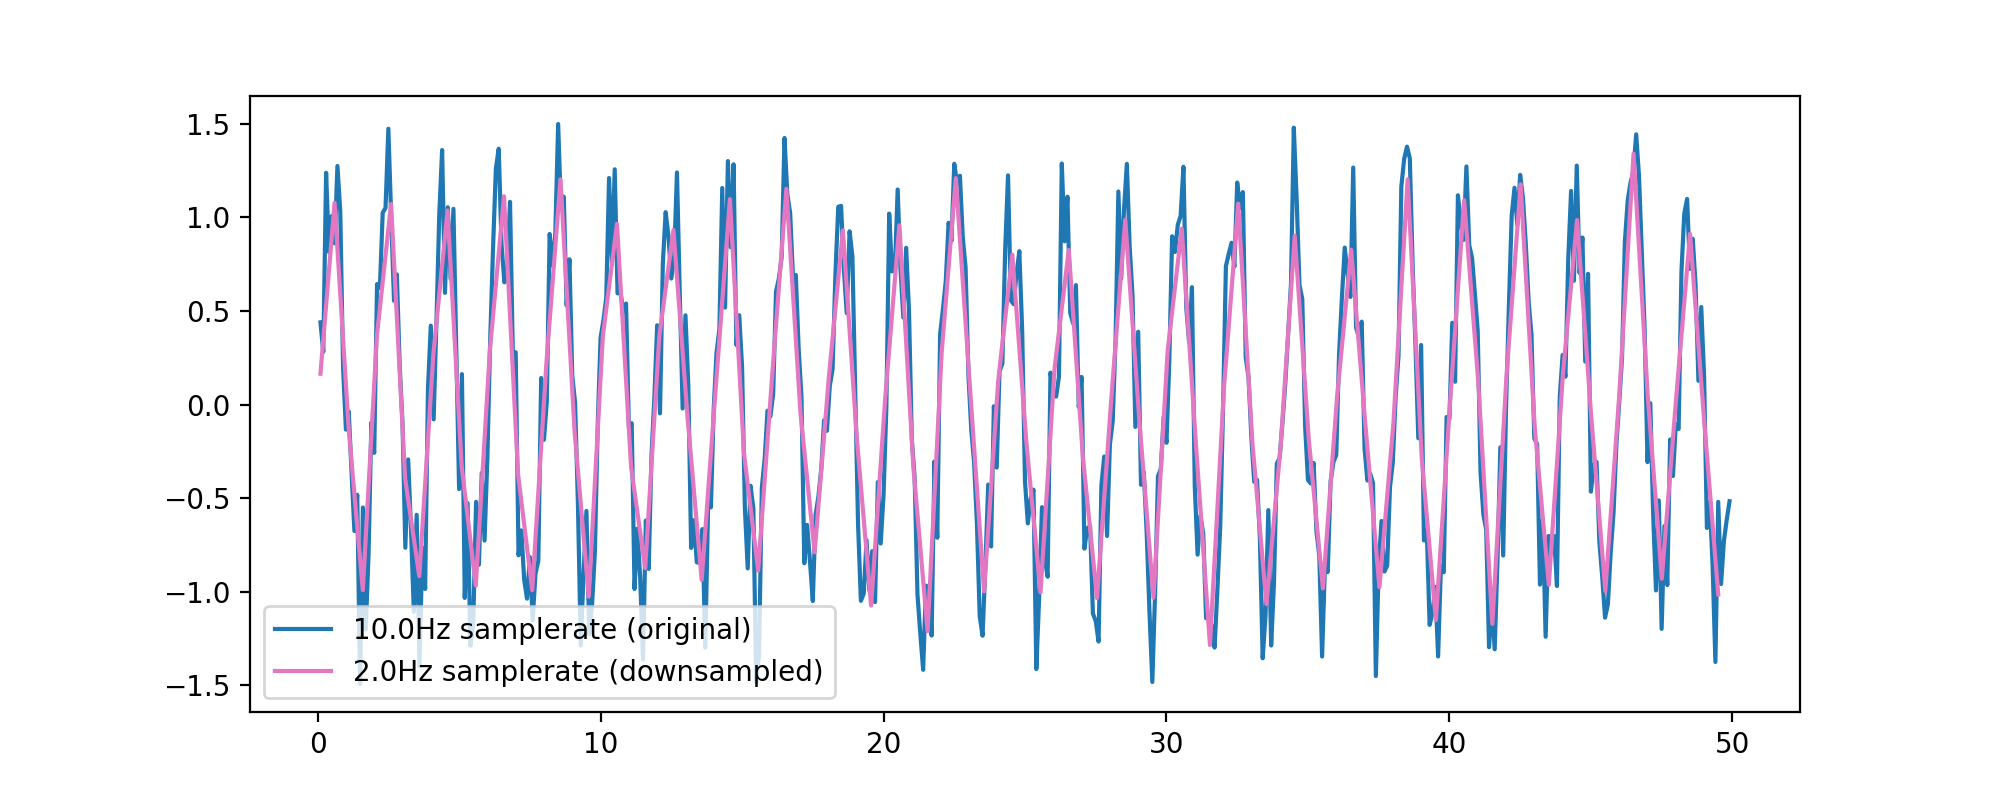

In [18]:
plt.figure(figsize=[10, 4])
plt.plot(original.time, original, color='C0', label='10.0Hz samplerate (original)')
plt.plot(downsampled.time, downsampled, color='C6', label='2.0Hz samplerate (downsampled)')
plt.legend()

<p>However, as we downsample to lower frequencies, we lose precision of the signal.</p>
<p>Read more about the relationship between sampling rate and observed frequencies [here](https://en.wikipedia.org/wiki/Nyquist_frequency).</p>

<IPython.core.display.Javascript object>


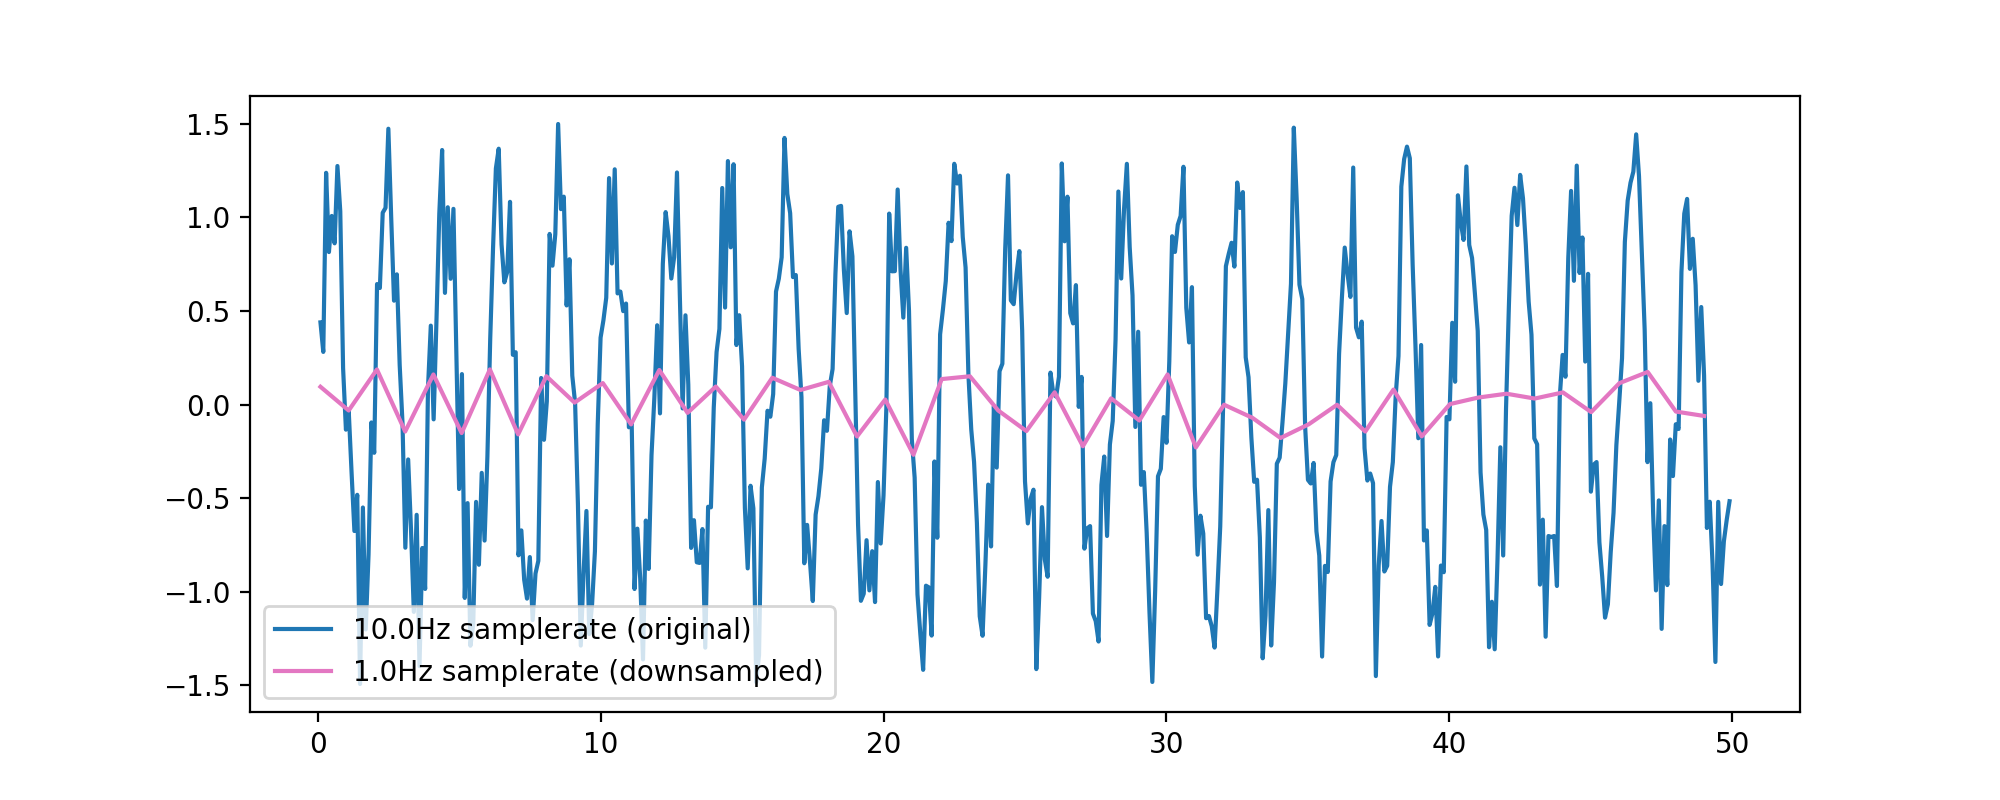

In [19]:
original = ts.sel(frequency=ts.frequency[0]).sel(time=ts.time<50.0)
downsampled = original.resampled(resampled_rate=1.0)

plt.figure(figsize=[10, 4])
plt.plot(original.time, original, color='C0', label='10.0Hz samplerate (original)')
plt.plot(downsampled.time, downsampled, color='C6', label='1.0Hz samplerate (downsampled)')
plt.legend()

In [20]:
# timeseries updates the samplerate for you
print original.samplerate
print downsampled.samplerate

<xarray.TimeSeriesX 'samplerate' ()>
array(10.)
Coordinates:
    samplerate  float64 10.0
    frequency   float64 0.5
<xarray.TimeSeriesX 'samplerate' ()>
array(1.)
Coordinates:
    samplerate  float64 1.0


## 7. Filtering your data
<p>Let's create a new timeseries composed of sinunoids at three different frequencies.  We'll show how to manipulate these data using different filtering methods.</p>

In [21]:
freq1 = 3.2
freq2 = 1.6
freq3 = 0.2

data1 = np.sin(2*np.pi*freq1*t)
data2 = np.sin(2*np.pi*freq2*t)
data3 = np.sin(2*np.pi*freq3*t)

# our data are simply the sum of the three sinusoids
data = data1 + data2 + data3

In [22]:
ts = timeseries(data, dims=('time'), coords={'time':t, 'samplerate':sample_rate})
ts

<xarray.TimeSeriesX (time: 5000)>
array([ 1.874488e+00,  3.830037e-01,  2.447679e-01, ..., -3.830037e-01,
       -1.874488e+00,  9.821934e-14])
Coordinates:
    samplerate  float64 10.0
  * time        (time) float64 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 ...

<IPython.core.display.Javascript object>


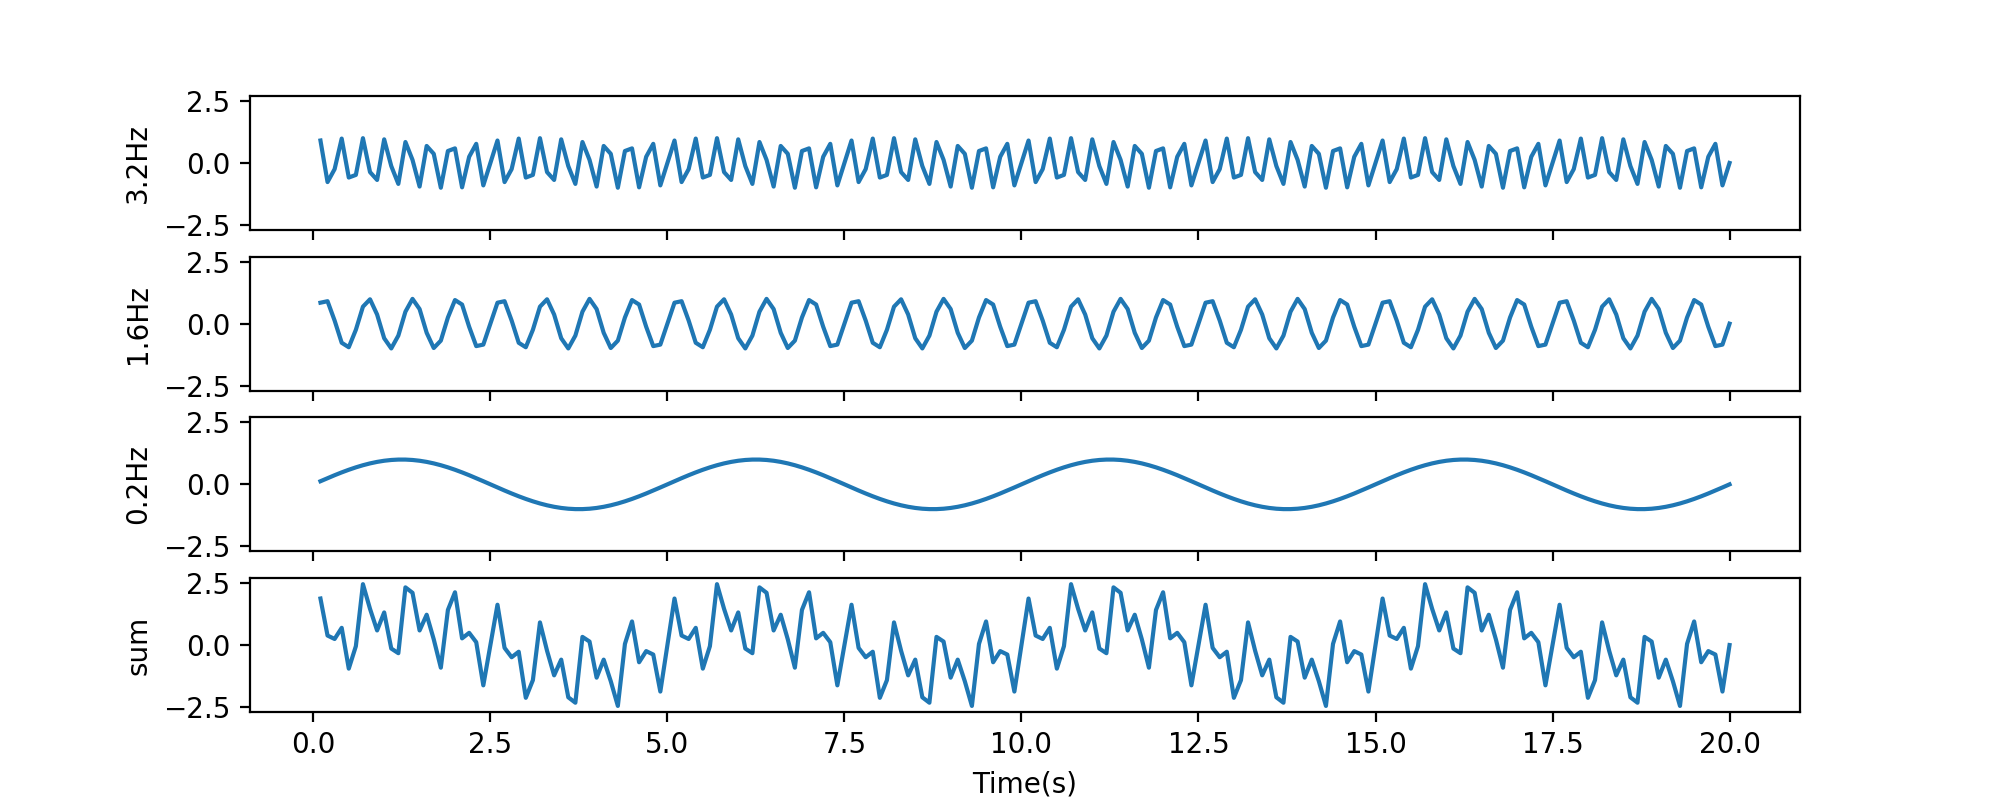

Text(0.5,0,u'Time(s)')

In [23]:
# Let's plot the first 200 samples of the data
fig, ax = plt.subplots(4, figsize=[10, 4], sharex=True, sharey=True)
ax[0].plot(t[:200], data1[:200])
ax[1].plot(t[:200], data2[:200])
ax[2].plot(t[:200], data3[:200])
ax[3].plot(t[:200], ts[:200])

ax[0].set_ylabel('3.2Hz')
ax[1].set_ylabel('1.6Hz')
ax[2].set_ylabel('0.2Hz')
ax[3].set_ylabel('sum')
ax[3].set_xlabel('Time(s)')

### We will use three different filters to filter out each component.  

<p> 1. To filter out the component with the highest frequency (3.2Hz), we'll use a lowpass filter. A lowpass filter perserves any frequency that is lower than the given frequency.  

2. To filter out the component with the lowest frequency (0.2Hz), we'll use a highpass filter. A highpass filter perserves any frequency that is higher than the given frequency.  

3. To filter out the component with the middle frequency (1.6Hz), we'll use a bandstop filter. A bandstop filter perserves any frequency that is outside of the given frequency range.
</p>

<p>Note that these filters suffer from edge effects at both ends of the timeseries.</p>

/home1/liyuxuan/anaconda3/envs/PTSA/lib/python2.7/site-packages/ptsa/data/TimeSeriesX.py:264: UserWarning: The filtered method is not very flexible. Consider using filters in ptsa.data.filters instead.
  warnings.warn("The filtered method is not very flexible. "


<IPython.core.display.Javascript object>


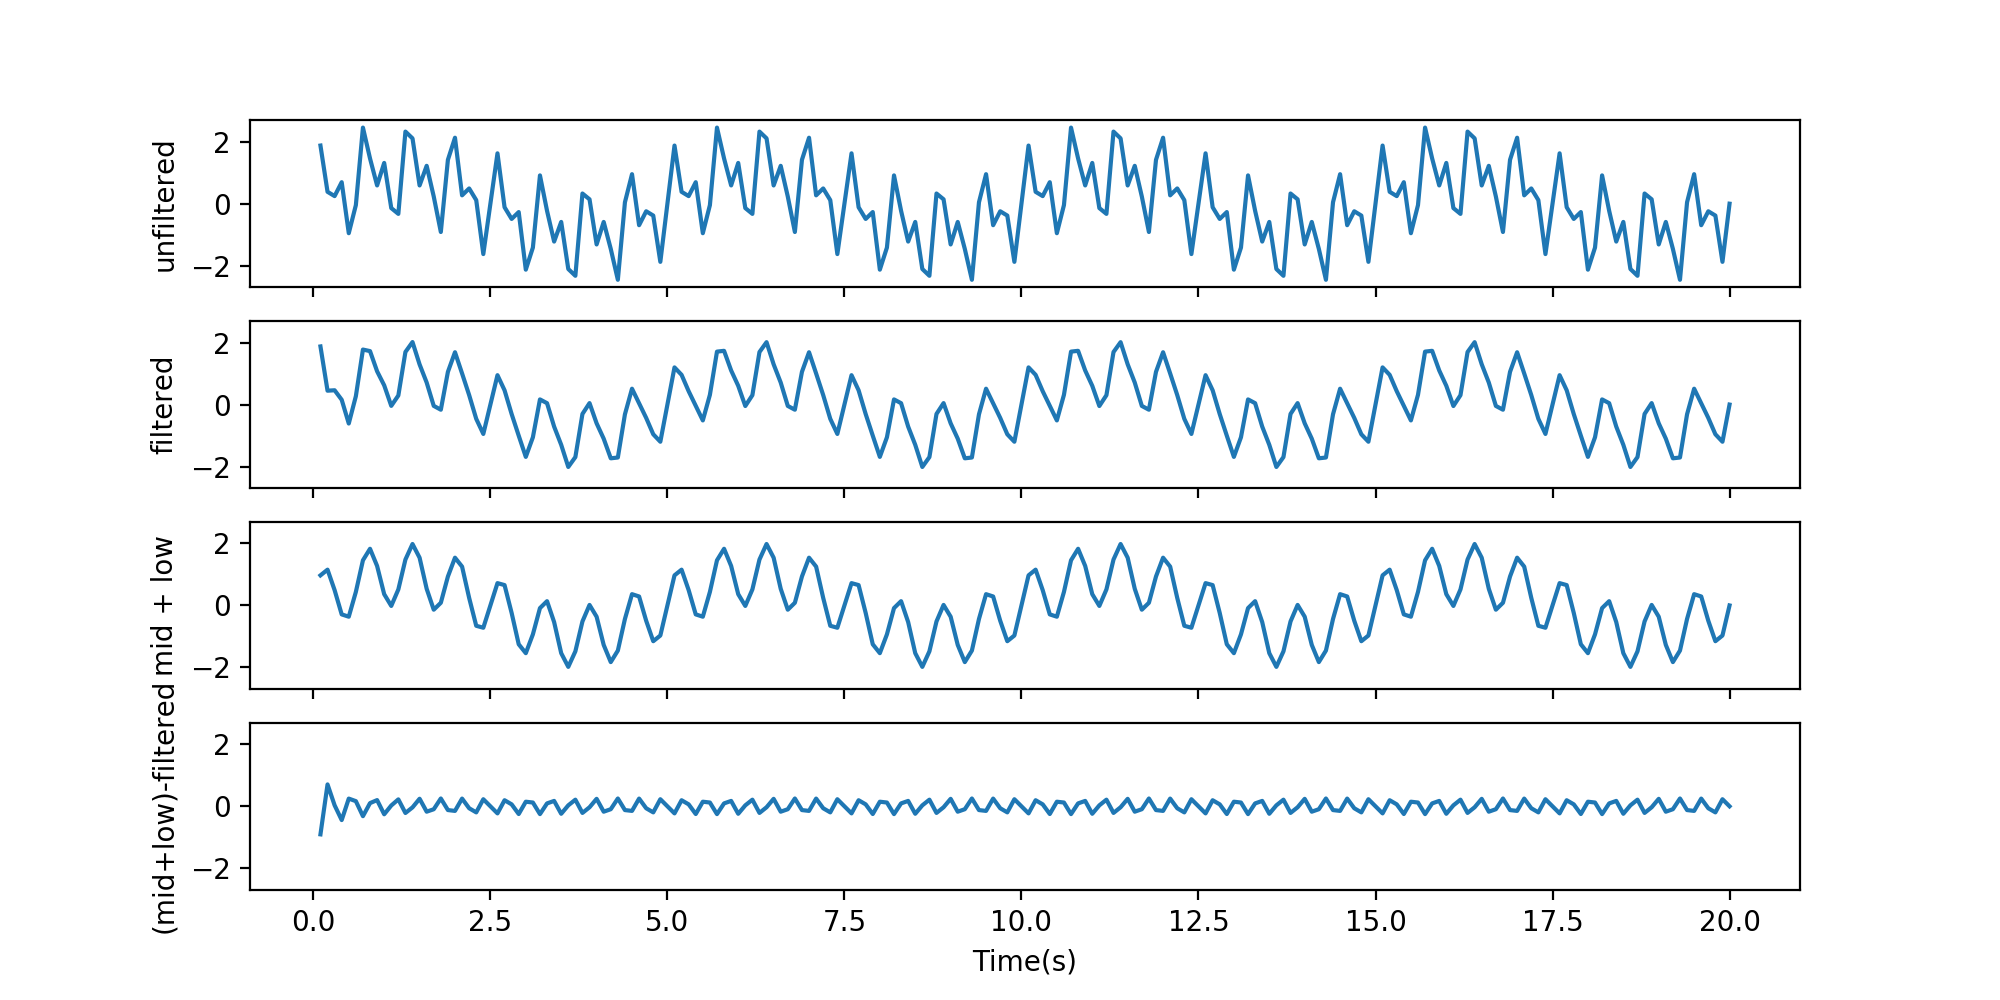

Text(0.5,0,u'Time(s)')

In [24]:
# lowpass filter
filtered_data = ts.filtered(3.0, filt_type='lowpass', order=4)

fig, ax = plt.subplots(4, figsize=[10, 5], sharex=True, sharey=True)

ax[0].plot(t[:200], ts[:200]) # origianl timeseries
ax[1].plot(t[:200], filtered_data[:200]) # losspass filtered
ax[2].plot(t[:200], (data2+data3)[:200]) # what we should get (mid + low frequencies)
ax[3].plot(t[:200], (data2+data3-filtered_data)[:200]) # the difference between what we should get and what we got should be close to zero

ax[0].set_ylabel('unfiltered')
ax[1].set_ylabel('filtered')
ax[2].set_ylabel('mid + low')
ax[3].set_ylabel('(mid+low)-filtered')
ax[3].set_xlabel('Time(s)')

<IPython.core.display.Javascript object>


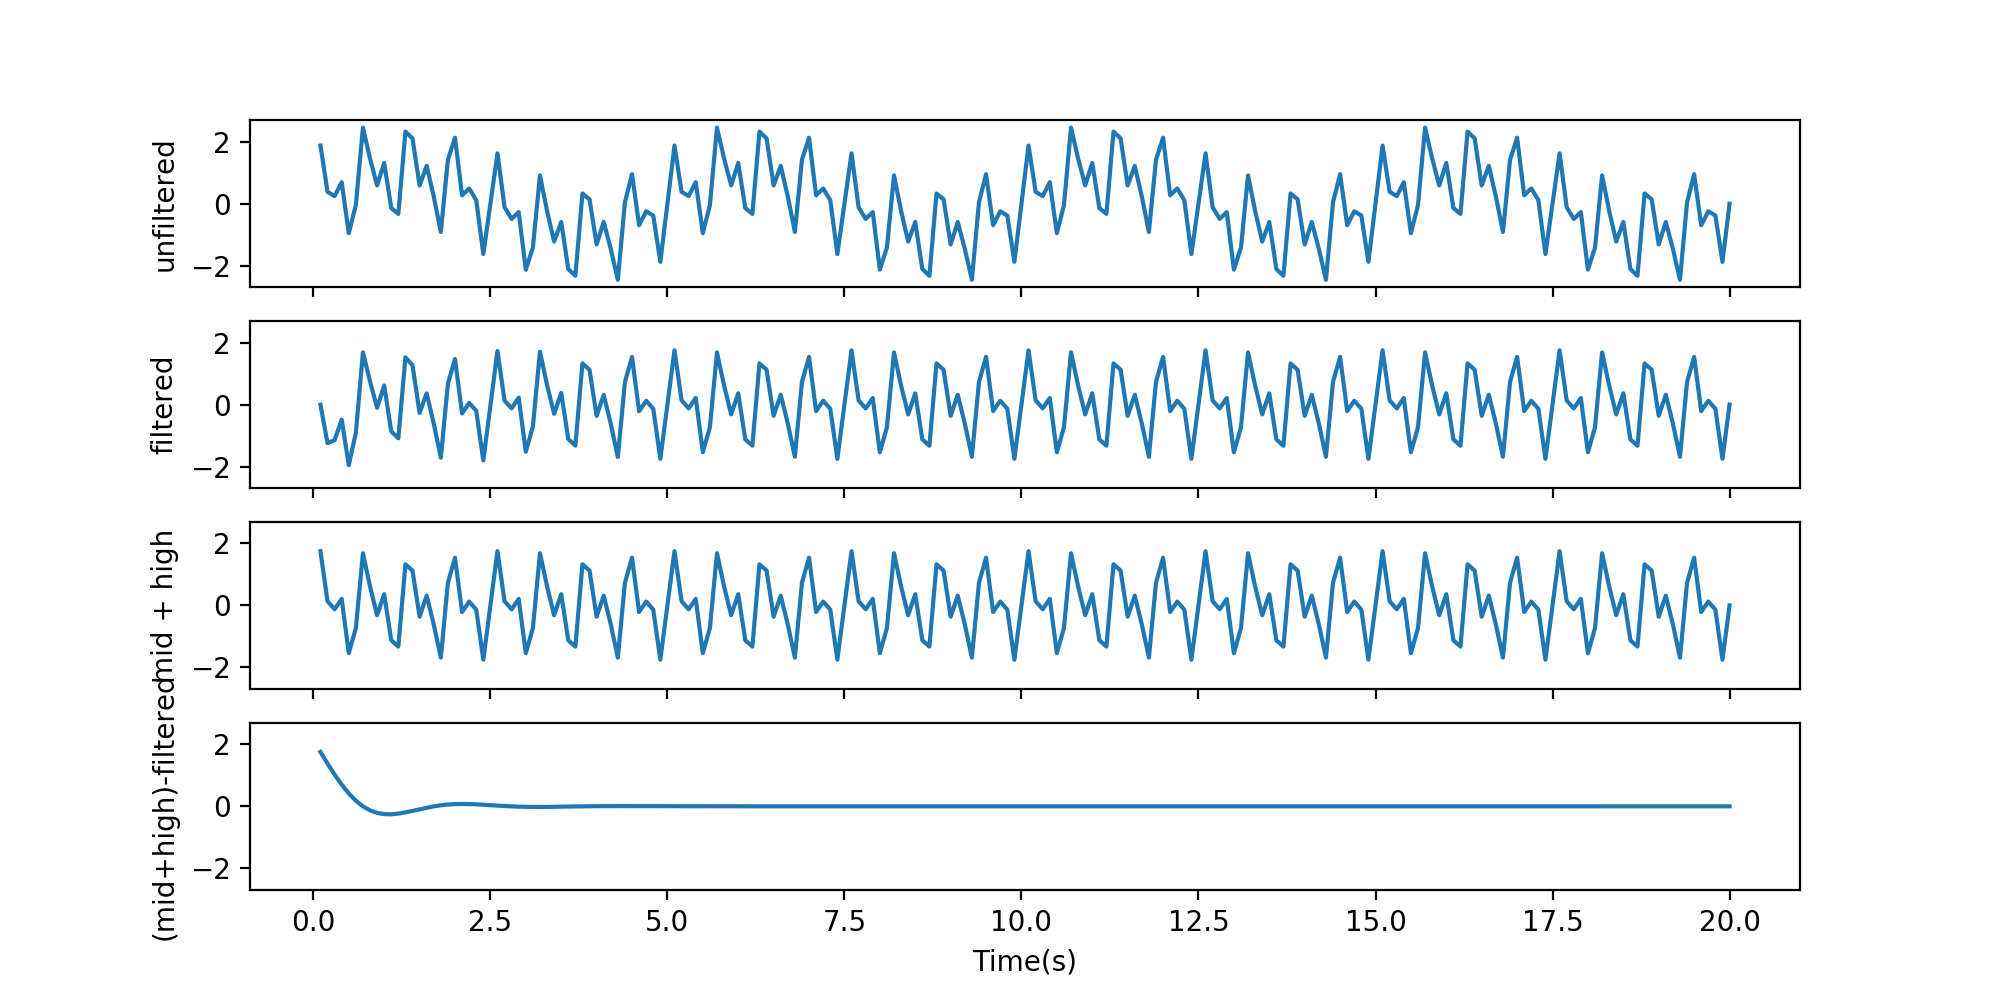

Text(0.5,0,u'Time(s)')

In [25]:
# highpass filter
filtered_data = ts.filtered(0.5, filt_type='highpass', order=4)

fig, ax = plt.subplots(4, figsize=[10, 5], sharex=True, sharey=True)

ax[0].plot(t[:200], ts[:200]) # origianl timeserids
ax[1].plot(t[:200], filtered_data[:200]) # highpass filtered
ax[2].plot(t[:200], (data2+data1)[:200]) # what we should get (mid + high frequencies)
ax[3].plot(t[:200], (data2+data1-filtered_data)[:200]) # the difference between what we should get and what we got should be close to zero

ax[0].set_ylabel('unfiltered')
ax[1].set_ylabel('filtered')
ax[2].set_ylabel('mid + high')
ax[3].set_ylabel('(mid+high)-filtered')
ax[3].set_xlabel('Time(s)')

<IPython.core.display.Javascript object>


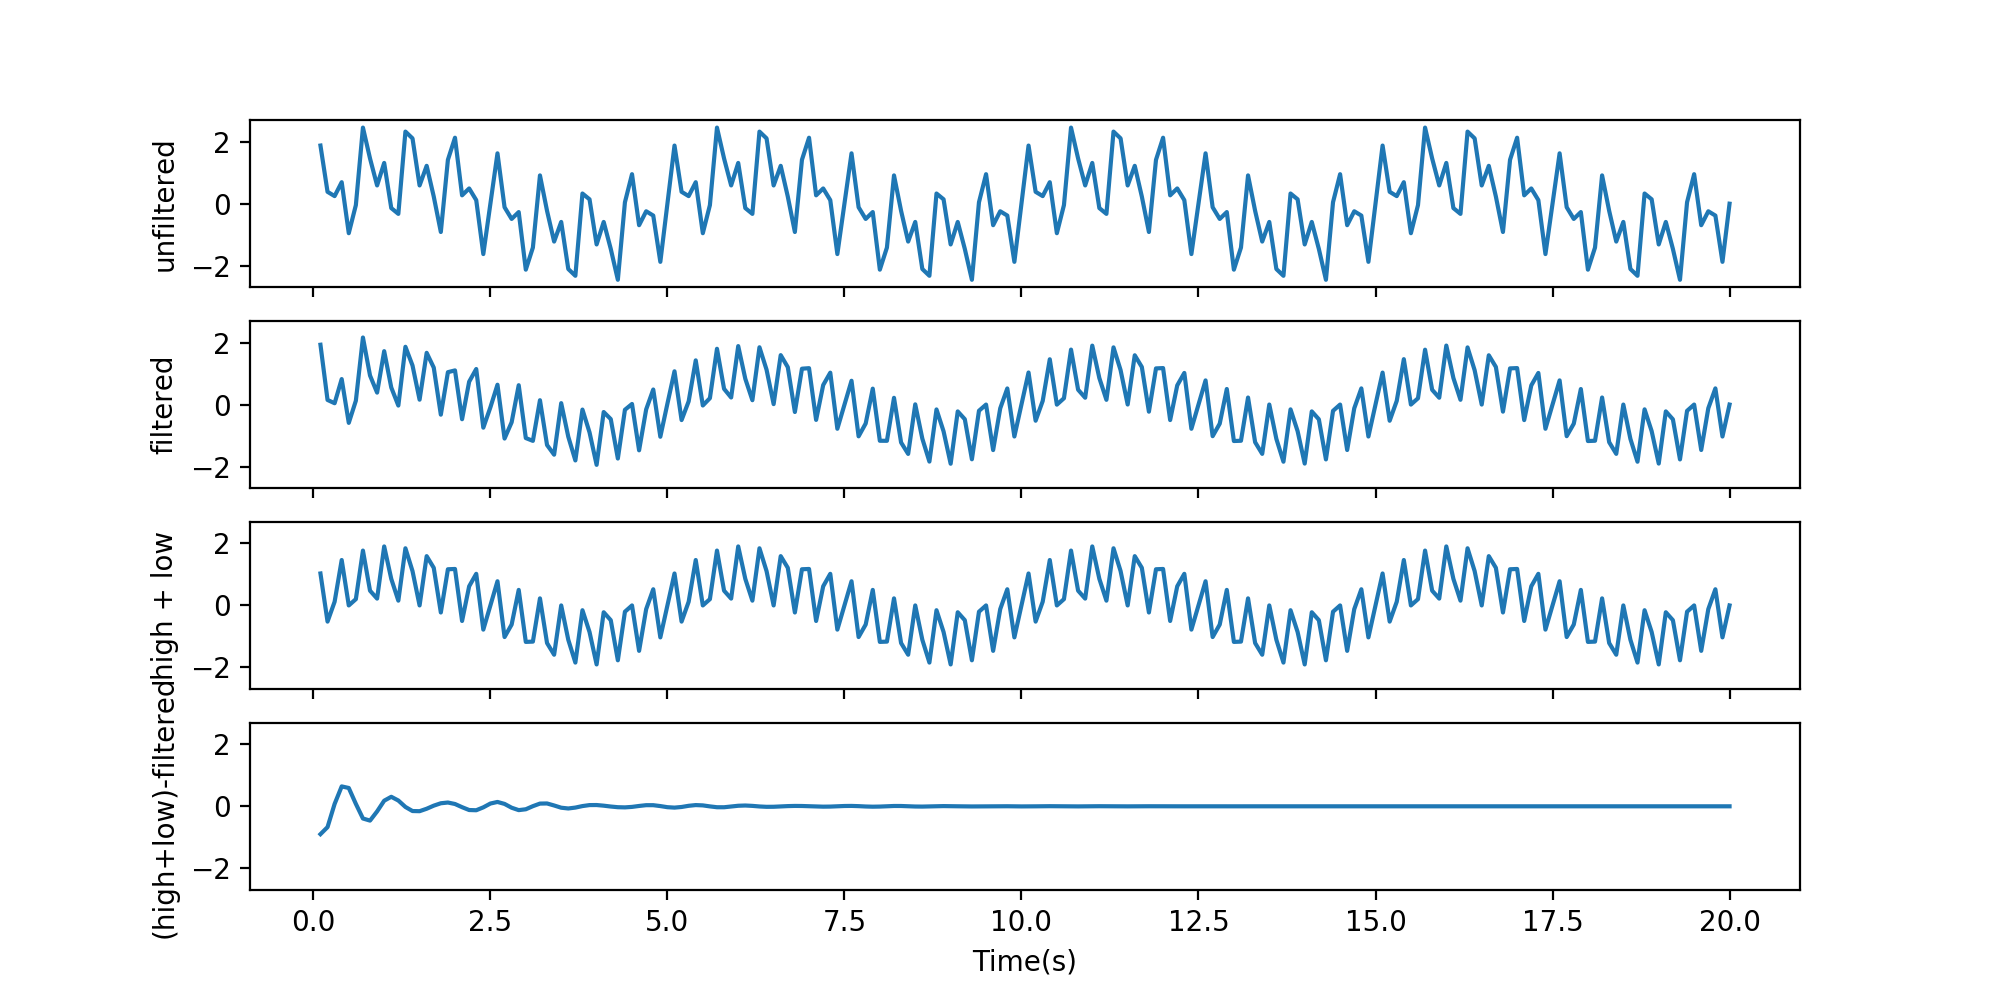

Text(0.5,0,u'Time(s)')

In [26]:
# bandstop filter
filtered_data = ts.filtered([1.4, 1.8], filt_type='stop', order=4)

fig, ax = plt.subplots(4, figsize=[10, 5], sharex=True, sharey=True)

ax[0].plot(t[:200], ts[:200]) # origianl timeserids
ax[1].plot(t[:200], filtered_data[:200]) # bandstop filtered
ax[2].plot(t[:200], (data1+data3)[:200]) # what we should get (high + low frequencies)
ax[3].plot(t[:200], (data1+data3-filtered_data)[:200]) # the difference between what we should get and what we got should be close to zero

ax[0].set_ylabel('unfiltered')
ax[1].set_ylabel('filtered')
ax[2].set_ylabel('high + low')
ax[3].set_ylabel('(high+low)-filtered')
ax[3].set_xlabel('Time(s)')

## There you have it! You're now ready to get rolling with PTSA's timeseries.